<a href="https://colab.research.google.com/github/anilkeshwani/StatLearnProj/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Notebook

The aim of this notebook is to create a single strand of analysis with a coherent narrative. 

[Update the results on the Google Sheet](https://docs.google.com/spreadsheets/d/1tFsScPgzPsGqZCGhDM3cJgXysmp_lce1kUN76B2Rha8/edit?usp=sharing)

### Aim for Final Version

- Table of Vectorisation Methods * Classification Method * |Additional Methods| - Table of accuracies for different combinations of analysis methods as detailed in _Table of Analyses.xlsx_ (see `organisation/` directory)
- Explanation/Exposition of methods
- EDA - Visualise vector word representations out of different pre-processing; Basic descriptive statistics on final _input dataset_
- Clear and clean pre-processing pipeline
- Clear and clean grid search methods

### Modelling Combinations

#### Pre-processing

- Components (methods) of `CleanText`
    - In particular stemming

#### Word Representations

- Bag-of-Words - One-Hot (BOW)
    - BOW n-grams with $n > 1$
- Bag-of-Words - Frequencies (FBOW)
- Term Frequency–Inverse Document Frequency (TF-IDF)
- Word2Vec
    - Skip-grams (SG)
    - Continuous-Bag-of-Words CBOW
- FastText
- Bert

#### Classifiers

- Logistic Regression (Elastic Net)
    - Search across penalisation weights (C) and l1-l2 ratios (l1_ratio)
- Support Vector Machines (SVM)
- Naive Bayes (NB)
- Random Forests (RF)
- Gradient Boosting (GB)
- (Perceptron) (MLP)

#### Additional Modelling Considerations

- Scaled versus Unscaled data

### Questions for the Team

- Logistic Regression: Thoughts on mean accuracy as given by `LogisticRegression.score()`?
- Logistic regression was fitted on individual words previously in Felicie's notebok. Given that we have a limited number of accounts, people might have tendencies to use the same words so our low train and test errors might come from here. Stemming reduces the training and test accuracies. **We should check if the components explaining a high degree of variation are individual words used by certain accounts.**
- What should our cut-off for the minimum _document frequency_ of words be. The value 10 has been used, but 1 is the default with `CountVectorizer`.

### Messages to the Team

- The repo is public - This allows us to directly read data in by passing Pandas a URL
- You can run code via AWS as if you're working locally. Follow [this tutorial](https://chrisalbon.com/aws/basics/run_project_jupyter_on_amazon_ec2/).

### TODO

- How has Felicie's approach to BOW vectorisation been realised by `sklearn.feature_extraction.text.CountVectorizer`? In particular, has any stemming been performed and if so via which algorithm? See the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
- Which dimensions explain the most variation? Inspect model coefficients; run PCA

# Code

In [ ]:
# Start Fresh
 
%reset -f
! pip install emoji
! pip install catboost
import csv  # for slang
import os
import re  # regex
import string  # punct
from pprint import pprint
 
import emoji  # for emoji
import gensim
import keras
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import sklearn
from gensim.models import Word2Vec
from IPython.display import Image
from matplotlib import pyplot as plt
from nltk.corpus import stopwords  # stopwords
from nltk.stem import PorterStemmer  # stemming
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import svm, tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, RandomForestRegressor,
                              StackingClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             brier_score_loss, classification_report,
                             confusion_matrix, f1_score, fbeta_score,
                             make_scorer, plot_precision_recall_curve,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC  # "Support vector classifier"
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
 
import catboost as cb
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
 
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import nltk
nltk.download('stopwords')
from operator import itemgetter

 
%matplotlib inline
from IPython.display import clear_output
 
#from google.colab import files # to read slang.txt until better solution is foun
#uploaded = files.upload()
import time
start_time = time.time()
clear_output()

## Homemade Classes and Functions

In [ ]:
# Clean Text Class

class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        '''
        Remove mentions, like @Mplamplampla
        '''
        return re.sub(r'@+', '', input_text)
    
    def remove_urls(self, input_text):
        '''
        Remove the urls mention in a tweet
        '''
        input_text  = ' '.join([w for w in input_text.split(' ') if '.com' not in w])
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        input_text = input_text.replace('_','')
        input_text = input_text.replace(':','')
        return input_text
    
    def possessive_pronouns(self, input_text):
        '''
        Remove the possesive pronouns, because otherwise after tokenization we will end up with a word and an s
        Example: government's --> ["government", "s"]
        '''
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        '''
        Remove special and redundant characters that may appear on a tweet and that don't really help in our analysis
        '''
        input_text = input_text.replace("\r", " ") # Carriage Return
        input_text = input_text.replace("\n", " ") # Newline
        input_text = " ".join(input_text.split()) # Double space
        input_text = input_text.replace('"', '') # Quotes
        return input_text
    
    def remove_punctuation(self, input_text):
        '''
        Remove punctuation and specifically these symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        '''
        punct = string.punctuation # string with all the punctuation symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        '''
        Remove numbers
        '''
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        '''
        Convert all the sentences(words) to lowercase
        '''
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        '''
        Remove stopwords (refers to the most common words in a language)
        '''
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        '''
        Reduce the words to their stem
        '''
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def encode_decode(self, input_text):
        '''
        Remove weird characters that are result of encoding problems
        '''
        return  " ".join([k.encode("ascii", "ignore").decode() for k in input_text.split(" ")])
    
    
    def translator(self, input_text):
        '''
        Transform abbrevations to normal words
        Example: asap --> as soon as possible
        '''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = "/content/slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that 
                # abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords)
                    .apply(self.stemming))
        return clean_X
    
    def transform_no_stem(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords))
        return clean_X

## Read in Data and Create Train and Test Sets

In [ ]:
# Read in data (Raw copy for reference; copy for processing)
 
tweets_raw = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


## Clean Dataset

Applies the class methods (leveraging `sklearn` API):

- translator
- remove_mentions
- remove_urls
- emoji_oneword
- possessive_pronouns
- remove_punctuation
- remove_digits
- encode_decode
- characters
- to_lower
- remove_stopwords
- stemming (via Porter Algorithm)

In [ ]:
# Text Cleaning
ct = CleanText()
tweets["text"] = ct.fit_transform(tweets.text)
tweets = tweets.loc[(~tweets.text.isnull()), :]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default
 
[print(dat.head(3), dat.shape, end="\n"*2) for dat in [X_train, X_test, Y_train, Y_test]];

3641     insect integr part life environ increas heat c...
11837                                  believ climat chang
8450              climat model need worri programm set run
Name: text, dtype: object (14407,)

8375          climat scienc settl sustain stagnant
6110          call climat plan good start joebiden
16330    obama govern need save planet global warm
Name: text, dtype: object (3602,)

3641     0
11837    1
8450     1
Name: label, dtype: int64 (14407,)

8375     1
6110     0
16330    1
Name: label, dtype: int64 (3602,)



In [ ]:
print(f"Training label counts: \n{Y_train.value_counts()}", end="\n"*2)
print(f"Test label counts: \n{Y_test.value_counts()}")

Training label counts: 
1    8433
0    5974
Name: label, dtype: int64

Test label counts: 
1    2138
0    1464
Name: label, dtype: int64


In [ ]:
# Save set of workspace objects' names to enable periodic clean-up
 
necessities = set(dir())

## Word Vectorisations

### Bag of Words (BOW) Binary ("One-Hot") Representation

In [ ]:
# Bag of Words Representation (One Hot, i.e. binary)
 
BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = 10)
BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)

In [ ]:
# Most frequently occurring words in the training corpus
 
[(index, word) for index, word in sorted(BOW_vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)][:20]

[('zero', 2214),
 ('yr', 2213),
 ('youtub', 2212),
 ('youthvgov', 2211),
 ('youthtopow', 2210),
 ('youthclimatesummit', 2209),
 ('youth', 2208),
 ('young', 2207),
 ('york', 2206),
 ('yesterday', 2205),
 ('year', 2204),
 ('yeah', 2203),
 ('ye', 2202),
 ('yall', 2201),
 ('yale', 2200),
 ('ya', 2199),
 ('wwf', 2198),
 ('wsj', 2197),
 ('wrote', 2196),
 ('wrong', 2195)]

### Bag of Words with Frequencies Representation (FBOW)

In [ ]:
# Bag of Words Representation (Frequencies; binary=False)
 
FBOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                  binary=False, # Creates Word Frequency Vector; 
                                                # # np.unique(FBOW_train.toarray())
                                  min_df = 10)
FBOW_vectorizer.fit(X_train)
FBOW_train = FBOW_vectorizer.transform(X_train)
FBOW_test = FBOW_vectorizer.transform(X_test)

In [ ]:
# Word use (per tweet) frequencies
 
print(np.unique(FBOW_train.toarray(), return_counts=True))
 
# Feature_Index: Word Mapping
 
# {v: k for k, v in FBOW_vectorizer.vocabulary_.items()}

(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 13]), array([31778480,   127451,     5139,      375,       48,        4,
              5,        1,        1,        1]))


### Bag of Words Bigrams (bigram)

In [ ]:
bigram_vectorizer = CountVectorizer(stop_words = 'english', 
                                    binary=True, 
                                    min_df = 10,
                                    ngram_range = (1,2)) # create bigrams
bigram_vectorizer.fit(X_train)
 
bigram_train = bigram_vectorizer.transform(X_train)
bigram_test = bigram_vectorizer.transform(X_test)

### Term Frequency–Inverse Document Frequency Representation (tf-idf)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=10) # used for now for consistency
tfidf_vectorizer.fit(X_train)
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
 
# Construct Scaled Datasets
 
scaler_tfidf = MaxAbsScaler()
tfidf_train_scaled = scaler_tfidf.fit_transform(tfidf_train)
tfidf_test_scaled = scaler_tfidf.transform(tfidf_test)

### Word2Vec - Continuous-Bag-of-Words

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


KeyboardInterrupt: ignored

In [ ]:
tweets = pd.read_csv("https://github.com/anilkeshwani/StatLearnProj/raw/master/Anil/clean_tweets_no_stemming.csv")

#### Add clean text field containing only words known to pretrained Word2Vec

In [ ]:
tweets["text_clean_known"] = tweets.text_clean.apply(func=lambda tweet: ' '.join([word for word in tweet.split() \
                                                                               if word in wv.vocab]))
print(f"Count of text_clean_known entries which are null: {sum(tweets.text_clean_known.isnull())}")
print(f"Count of text_clean_known entries which empty: \
{sum(tweets.text_clean_known.apply(func=lambda x: x.strip() == ''))}")
 
# Remove both rows with either null or empty `text_clean_known` entries
 
tweets = tweets.loc[(~tweets.text_clean_known.isnull()), :]
tweets = tweets.loc[~tweets.text_clean_known.apply(func=lambda x: x.strip() == ''), ]
 
print("After cleaning:", end="\n")
print(f"Count of text_clean_known entries which are null: {sum(tweets.text_clean_known.isnull())}")
print(f"Count of text_clean_known entries which empty: {sum(tweets.text_clean_known.apply(func=lambda x: x.strip() == ''))}")

NameError: ignored

#### Calculate Tweet Vectors

##### Implement Tweet Vectorizer: Word2VectorizeTweet

- Retrieves vector for words (where possible; although input here is clean, there is a fallback for unrecognised word keys)
- **Takes (component-wise; arithmetic) mean of word vectors to calculate a _tweet vector_**
- Tracks number of words for which vector entries exist in the (pre-trained) vocabulary (used for average)

NB Could have done this by precalcuting number of token per tweet document given that we have clean and known (to Word2Vec) input, but I kept the function as it was before, when I was using input that optionally contained _unknown_ words. Not sure if the speed improvement is critical. 

In [ ]:
def Word2VectorizeTweet(tweet):
    tweet_vector = np.zeros(shape=(300,), dtype="float32")
    n_vectorizable = 0
    for word in tweet.split():
        try:
#             print(f"Adding {word} to word representation")
            tweet_vector = np.add(tweet_vector, wv.get_vector(word))
            n_vectorizable += 1
        except KeyError:
            print(f"Could not vectorize {word}")
    return (tweet_vector/n_vectorizable)

In [ ]:
tweets["wv"] = tweets.text_clean_known.apply(func=Word2VectorizeTweet)

#### Create Word2Vec-Representation Input Dataset - Vector Mean Method

In [ ]:
w2v_train, w2v_test, Y_train_wv, Y_test_wv = train_test_split(np.array(tweets.wv.tolist()), tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

#### Visualisation of Tweets

Open the figure elsewhere (e.g. another browser tab) and pan around to read the tweets (messy but quick solution to viewing).

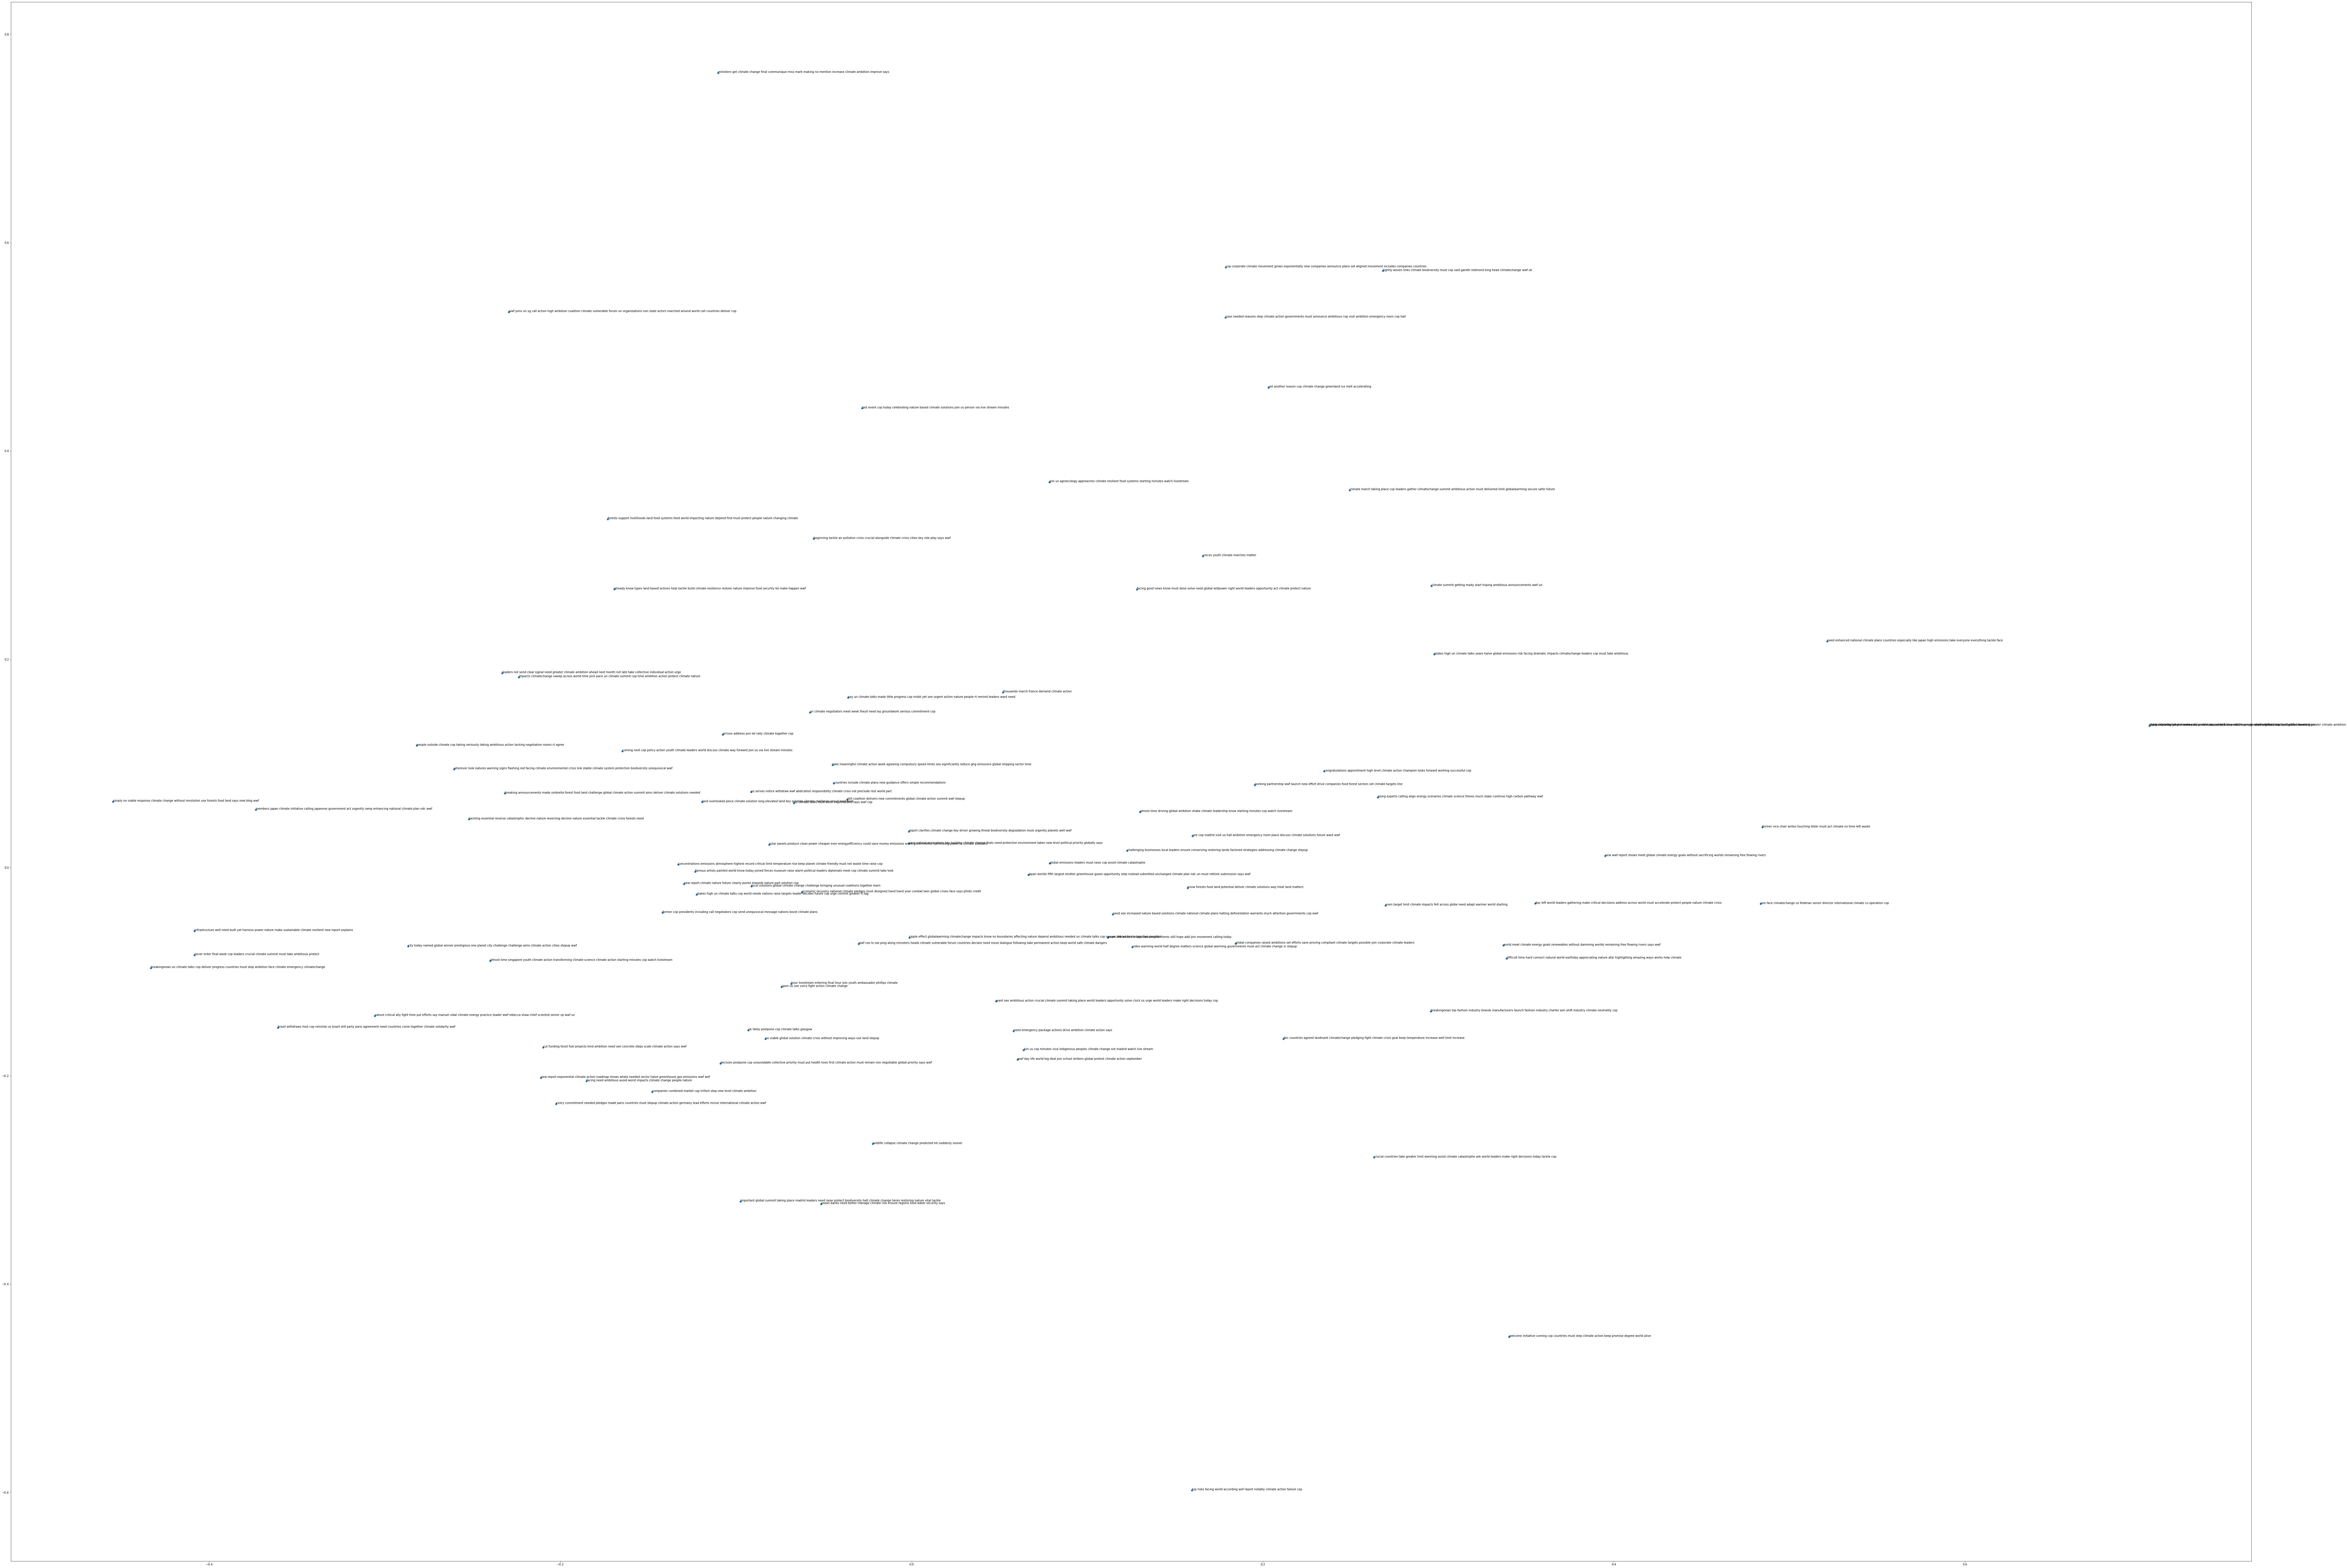

In [ ]:
plt.figure(figsize=(140, 100))
 
pca = PCA(n_components=2)
pca_results = pca.fit_transform(w2v_train)
 
plt.scatter(pca_results[:100, 0], pca_results[:100, 1])
 
for i, text in enumerate(list(tweets.text_clean_known)[:100]):
    plt.annotate(text[:], xy=(pca_results[i, 0], pca_results[i, 1]))
plt.show()

## Grid-Searches - Best Estimators Result 
Here we provide the code we run on our machines locally and then we show the result for the best hyperparameters we got 

In [ ]:
#kfcv = KFold(n_splits=5,shuffle=True,random_state=101)



*   Bag of Words (BOW) Binary ("One-Hot") Representation


> Logistic Regression






In [ ]:
#param_grid = {
#            'penalty': ['elasticnet','l1','l2','none'],
#            'C': [.001, .01, .1, 1, 10, 100, 1000],
#            'solver': ['liblinear', "saga", "lbfgs", "newton-cg", "sag"],
#            'multi_class': ['ovr'],
#            'max_iter' : [1000]
#        }
#grid_search_LR = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_LR.fit(BOW_train,Y_train)
#clear_output()
#print("## Best Logistic Regression parameters with BOW embedding :", grid_search_LR.best_params_)

In [ ]:
clf_BOW_LG = LogisticRegression(C = 1, max_iter = 1000, multi_class = "ovr")
clf_BOW_LG.fit(BOW_train, Y_train)
clear_output()



> Random Forests





In [ ]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 100, None],
#    'max_features': ['sqrt', 'log2'],
#    'min_samples_leaf': [1, 3, 5],
#    'min_samples_split': [2, 5, 10],
#    'n_estimators': [50, 100, 300]
#}
#grid_search_RF = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_RF.fit(BOW_train,Y_train)
#clear_output()
#print("## Best Random Forest parameters with BOW embedding :", grid_search_RF.best_params_)


In [ ]:
clf_BOW_RF = RandomForestClassifier(bootstrap=True, 
                       max_features='log2', 
                       max_depth=None,
                       min_samples_leaf=1,
                       min_samples_split=5,
                       n_estimators=300)
clf_BOW_RF.fit(BOW_train, Y_train)
clear_output()



> Support Vector Machine





In [ ]:
#param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1,2,10,100]},
#                    {'kernel': ['linear'], 'C': [1,2,10,100]}]
#grid_search_SVM = GridSearchCV(estimator = SVC(probability =True), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_SVM.fit(BOW_train,Y_train)
#clear_output()
#print("## Best Super Vector Machines parameters with BOW embedding :", grid_search_SVM.best_params_)

In [ ]:
clf_BOW_SVM = SVC(probability =True, C = 100, gamma = 0.001, kernel='rbf' )
clf_BOW_SVM.fit(BOW_train, Y_train)
clear_output()

> Cat Boost

In [ ]:
#param_grid = {'n_estimators':[100,250,500,1000],
#              'depth':sp_randint(1,10),
#              'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3], 
#              'l2_leaf_reg':[1,5,10,100],
#              'border_count':[5,10,20,50,100,200]}
#n_HP_points_to_test = 60
#grid_search_CB = RandomizedSearchCV(
#    estimator=cb.CatBoostClassifier(random_state=17,thread_count=4,verbose=0), 
#    param_distributions=param_grid, 
#    n_iter=n_HP_points_to_test,
#    scoring='accuracy',
#    cv=kfcv,
#    refit=True,
#    random_state=17,
#    n_jobs=-1,
#    verbose=5)
#grid_search_CB.fit(BOW_train,Y_train)
#clear_output()
#print("## Best Cat Boost parameters with BOW embedding :", grid_search_CB.best_params_)

In [ ]:
clf_BOW_CB =  cb.CatBoostClassifier(border_count = 200, 
                                    depth = 6, 
                                    l2_leaf_reg = 10, 
                                    learning_rate = 0.3,
                                    n_estimators = 1000,
                                    random_state=17,thread_count=4,verbose=0)
clf_BOW_CB.fit(BOW_train, Y_train)
clear_output()



> Gaussian Naives Bayes



In [ ]:
#var_smoothing = [pow(10,k)/1000000000 for k in range(10)]
#param_grid = {
#           'alpha': var_smoothing
#        }
#grid_search_NB = GridSearchCV(estimator = GaussianNB() , param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_NB.fit(BOW_train,Y_train)
#clear_output()
#print("## Best Gaussian Naives Bayes parameters with BOW embedding :", grid_search_NB.best_params_)

In [ ]:
clf_BOW_GNB =  GaussianNB(var_smoothing=0.001)
clf_BOW_GNB.fit(BOW_train.toarray(), Y_train)
clear_output()

Accuracy and visualisation of the results 

In [ ]:
def summary(list_best_grid,X_test,Y_test, word_representation,cb = True ):
  acc = []
  if cb:
    idx = ["Logistic Regression", "Random Forest", "Support Vector Machine", "CatBoost", "Gaussian Naive Bayes"]
  else:
    idx = ["Logistic Regression", "Random Forest", "Support Vector Machine",  "Gaussian Naive Bayes"]
  color = ["red", "orange", "blue", "pink", "green"]
  i = 0
  for clf in list_best_grid:
    if clf == list_best_grid[-1]:
      y_score = clf.predict_proba(X_test.toarray())[:, 1]
      acc.append(accuracy_score(clf.predict(X_test.toarray()), Y_test))
    else:
      y_score = clf.predict_proba(X_test)[:, 1]
      acc.append(accuracy_score(clf.predict(X_test), Y_test))
    fpr, tpr, _ = roc_curve(Y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color[i],lw=2, label=idx[i] + '(area = %0.2f)' % roc_auc)
    i +=1
  df = pd.DataFrame(acc, index = idx, columns = [word_representation])
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for ' + word_representation )
  plt.legend(loc="lower right")
  plt.show()
  return df

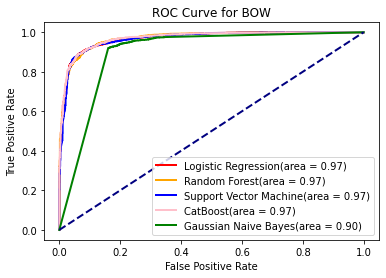

,BOW
Logistic Regression,0.909772
Random Forest,0.909495
Support Vector Machine,0.909772
CatBoost,0.909772
Gaussian Naive Bayes,0.886174


In [ ]:
BG_EST = [clf_BOW_LG, 
          clf_BOW_RF, 
          clf_BOW_SVM, 
          clf_BOW_CB, 
          clf_BOW_GNB]
summary(BG_EST, BOW_test,Y_test, "BOW")

Feature Importance
> Logistic Regression

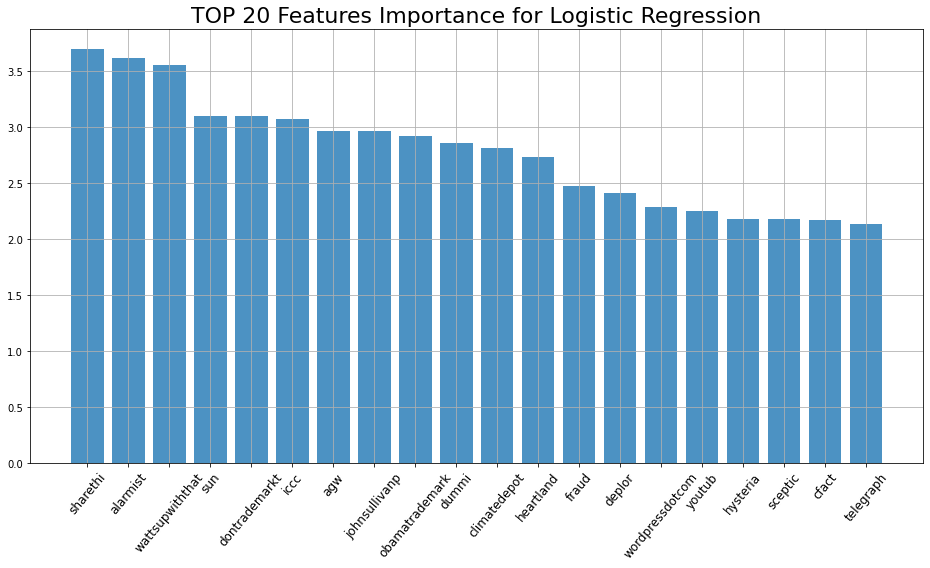

In [ ]:
importance = clf_BOW_LG.coef_[0]

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = BOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Logistic Regression',fontsize=22)
plt.grid()
plt.show()

> Random Forest

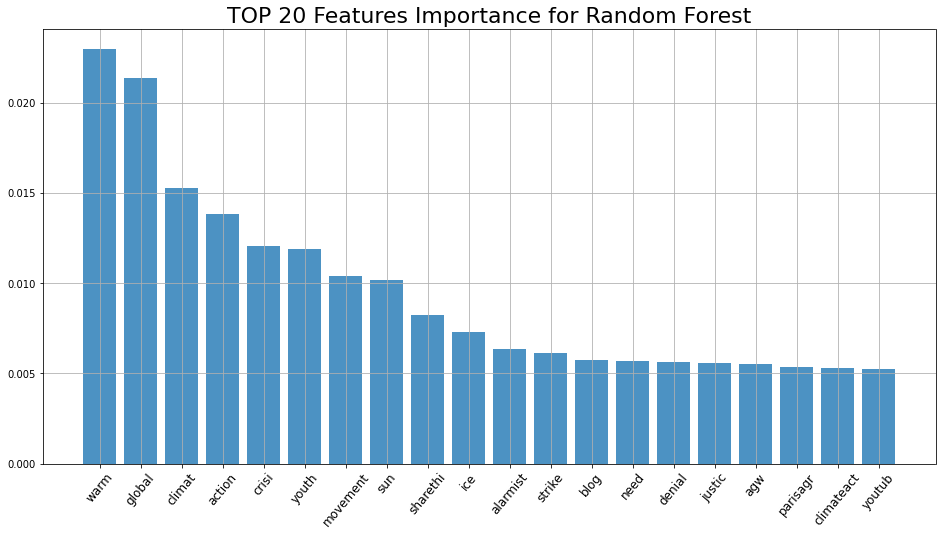

In [ ]:
importance = clf_BOW_RF.feature_importances_

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = BOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Random Forest',fontsize=22)
plt.grid()
plt.show()

> CatBoost

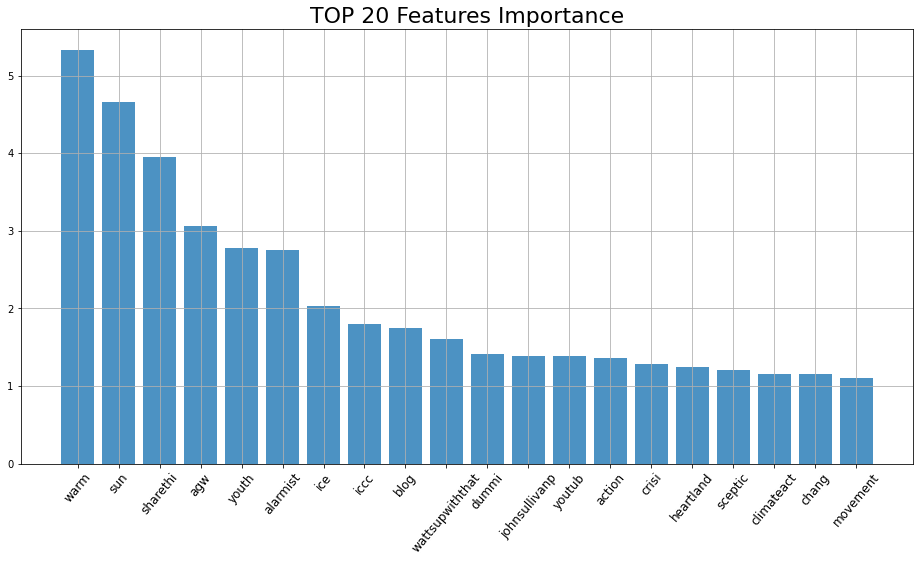

In [ ]:
importance = clf_BOW_CB.get_feature_importance()

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = BOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()



*   Bag of Words with Frequencies Representation (FBOW)


> Logistic Regression

In [ ]:
#param_grid = {
#            'penalty': ['elasticnet','l1','l2','none'],
#            'C': [.001, .01, .1, 1, 10, 100, 1000],
#            'solver': ['liblinear', "saga", "lbfgs", "newton-cg", "sag"],
#            'multi_class': ['ovr'],
#            'max_iter' : [1000]
#        }
#grid_search_LR = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2)
#grid_search_LR.fit(FBOW_train,Y_train)
#clear_output()
#print("## Best Logistic Regression parameters with FBOW embedding :", grid_search_LR.best_params_)

In [ ]:
clf_FBoW_LG = LogisticRegression(C = 1, max_iter = 1000, multi_class = "ovr", solver = "liblinear")
clf_FBoW_LG.fit(FBOW_train, Y_train)
clear_output()

> Random Forests


In [ ]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 100, None],
#    'max_features': ['sqrt', 'log2'],
#    'min_samples_leaf': [1, 3, 5],
#    'min_samples_split': [2, 5, 10],
#    'n_estimators': [50, 100, 300]
#}
#grid_search_RF = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2)
#grid_search_RF.fit(FBOW_train,Y_train)
#clear_output()
#print("## Best Random Forest parameters with FBOW embedding :", grid_search_RF.best_params_)


In [ ]:
clf_FBoW_RF = RandomForestClassifier(bootstrap = True,
                                     max_depth = None, 
                                     max_features = "log2",
                                     min_samples_leaf = 1,
                                     min_samples_split = 5, 
                                     n_estimators = 300)
clf_FBoW_RF.fit(FBOW_train, Y_train)
clear_output()


> Support Vector Machine


In [ ]:
#param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1,2,10,100]},
#                    {'kernel': ['linear'], 'C': [1,2,10,100]}]
#grid_search_SVM = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2, scoring='accuracy')
#grid_search_SVM.fit(FBOW_train,Y_train)
#clear_output()
#print("## Best Super Vector Machines parameters with FBOW embedding :", grid_search_SVM.best_params_)

In [ ]:
clf_FBoW_SVM = SVC(probability =True, C = 100, gamma = 0.001, kernel='rbf' )
clf_FBoW_SVM.fit(FBOW_train, Y_train)
clear_output()

> Cat Boost

In [ ]:
#param_grid = {'n_estimators':[100,250,500,1000],
#              'depth':sp_randint(1,10),
#              'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3], 
#              'l2_leaf_reg':[1,5,10,100],
#              'border_count':[5,10,20,50,100,200]}
#n_HP_points_to_test = 60
#grid_search_CB = RandomizedSearchCV(
#    estimator=cb.CatBoostClassifier(random_state=17,thread_count=4,verbose=0), 
#    param_distributions=param_grid, 
#    n_iter=n_HP_points_to_test,
#    scoring='accuracy',
#    cv=kfcv,
#    refit=True,
#    random_state=17,
#    n_jobs=-1,
#    verbose=5)
#grid_search_CB.fit(FBOW_train,Y_train)
#clear_output()
#print("## Best Cat Boost parameters with FBOW embedding :", grid_search_SVM.best_params_)

In [ ]:
clf_FBoW_CB =  cb.CatBoostClassifier(border_count = 200, 
                                    depth = 6, 
                                    l2_leaf_reg = 10, 
                                    learning_rate = 0.3,
                                    n_estimators = 1000,
                                    random_state=17,thread_count=4,verbose=0)
clf_FBoW_CB.fit(FBOW_train, Y_train)
clear_output()



> Gaussian Naives Bayes



In [ ]:
#var_smoothing = [pow(10,k)/1000000000 for k in range(10)]
#param_grid = {
#           'alpha': var_smoothing
#        }
#grid_search_NB = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2, scoring='accuracy')
#grid_search_NB.fit(FBOW_train,Y_train)
#clear_output()
#print("## Best Gaussian Naives Bayes parameters with FBOW embedding :", grid_search_SVM.best_params_)

In [ ]:
clf_FBoW_GNB =  GaussianNB(var_smoothing=0.001)
clf_FBoW_GNB.fit(FBOW_train.toarray(), Y_train)
clear_output()

Accuracy and visualisation of the results 

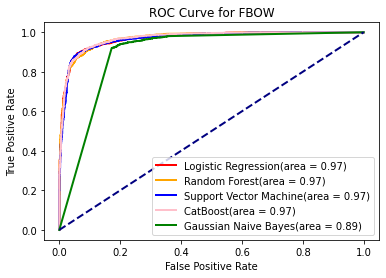

,FBOW
Logistic Regression,0.910050
Random Forest,0.908939
Support Vector Machine,0.906996
CatBoost,0.912826
Gaussian Naive Bayes,0.881177


In [ ]:
BG_EST = [clf_FBoW_LG, 
          clf_FBoW_RF, 
          clf_FBoW_SVM, 
          clf_FBoW_CB, 
          clf_FBoW_GNB]
summary(BG_EST, FBOW_test,Y_test, "FBOW")

Feature Importance
> Logistic Regression

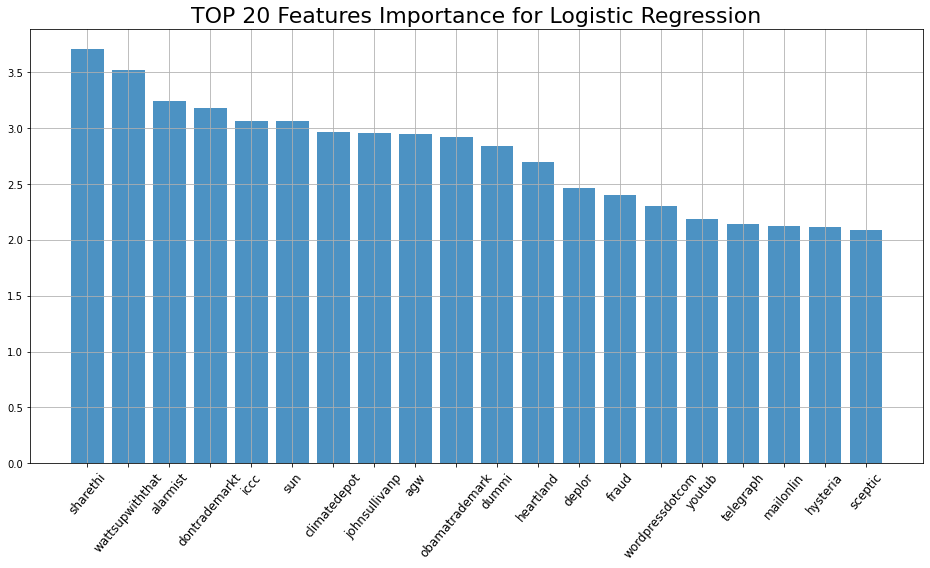

In [ ]:
importance = clf_FBoW_LG.coef_[0]

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = FBOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Logistic Regression',fontsize=22)
plt.grid()
plt.show()

> Random Forest

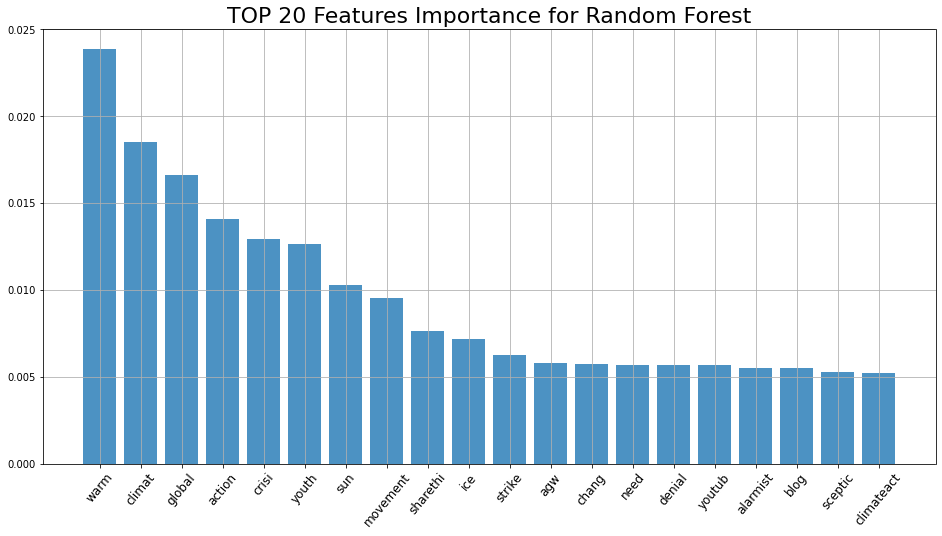

In [ ]:
importance = clf_FBoW_RF.feature_importances_

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = FBOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Random Forest',fontsize=22)
plt.grid()
plt.show()

> CatBoost

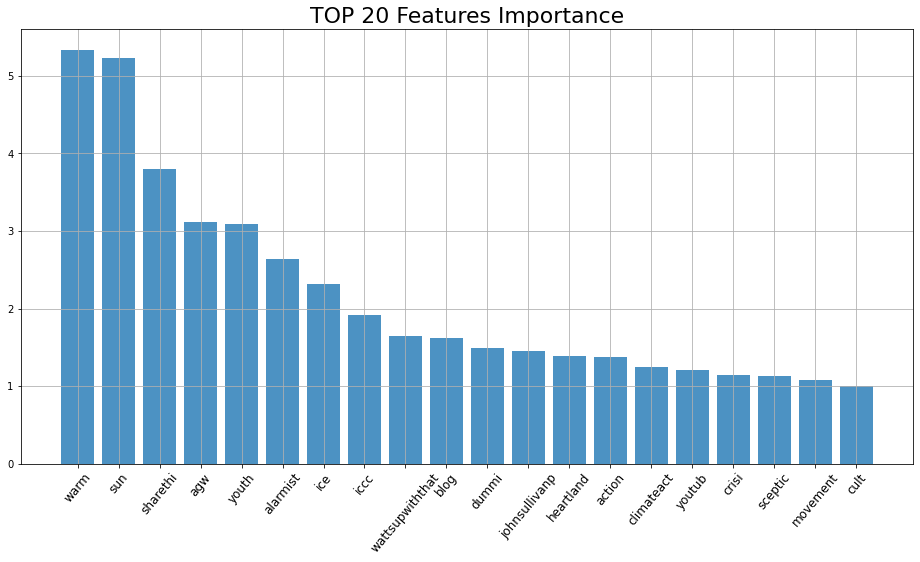

In [ ]:
importance = clf_FBoW_CB.get_feature_importance()

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = FBOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()



*   Bag of Words Bigrams (bigram)


> Logistic Regression

In [ ]:
#param_grid = {
#            'penalty': ['elasticnet','l1','l2','none'],
#            'C': [.001, .01, .1, 1, 10, 100, 1000],
#            'solver': ['liblinear', "saga", "lbfgs", "newton-cg", "sag"],
#            'multi_class': ['ovr'],
#            'max_iter' : [1000]
#        }
#grid_search_LR = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2)
#grid_search_LR.fit(bigram_train,Y_train)
#clear_output()
#print("## Best Logistic Regression parameters with BBOW embedding :", grid_search_LR.best_params_)

In [ ]:
clf_BBoW_LR = LogisticRegression(C = 1, max_iter = 1000, multi_class = "ovr", solver = "saga")
clf_BBoW_LR.fit(bigram_train, Y_train)
clear_output()



> Random Forests


In [ ]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 100, None],
#    'max_features': ['sqrt', 'log2'],
#    'min_samples_leaf': [1, 3, 5],
#    'min_samples_split': [2, 5, 10],
#    'n_estimators': [50, 100, 300]
#}
#grid_search_RF = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_RF.fit(bigram_train,Y_train)
#clear_output()
#print("## Best Random Forest parameters with BBOW embedding :", grid_search_RF.best_params_)


In [ ]:
clf_BBoW_RF = RandomForestClassifier(bootstrap = True,
                                     max_depth = None, 
                                     max_features = "log2",
                                     min_samples_leaf = 1,
                                     min_samples_split = 5, 
                                     n_estimators = 300)
clf_BBoW_RF.fit(bigram_train, Y_train)
clear_output()



> Support Vector Machine

In [ ]:
#param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1,2,10,100]},
#                    {'kernel': ['linear'], 'C': [1,2,10,100]}]
#grid_search_SVM = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_SVM.fit(bigram_train,Y_train)
#clear_output()
#print("## Best Super Vector Machines parameters with BBOW embedding :", grid_search_SVM.best_params_)

In [ ]:
clf_BBoW_SVM = SVC(probability =True, C = 100, gamma = 0.001, kernel='rbf' )
clf_BBoW_SVM.fit(bigram_train, Y_train)
clear_output()

> Cat Boost

In [ ]:
#param_grid = {'n_estimators':[100,250,500,1000],
#              'depth':sp_randint(1,10),
#              'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3], 
#              'l2_leaf_reg':[1,5,10,100],
#              'border_count':[5,10,20,50,100,200]}
#n_HP_points_to_test = 60
#grid_search_CB = RandomizedSearchCV(
#    estimator=cb.CatBoostClassifier(random_state=17,thread_count=4,verbose=0), 
#    param_distributions=param_grid, 
#    n_iter=n_HP_points_to_test,
#    scoring='accuracy',
#    cv=kfcv,
#    refit=True,
#    random_state=17,
#    n_jobs=-1,
#    verbose=5)
#grid_search_CB.fit(bigram_train,Y_train)
#clear_output()
#print("## Best Cat Boost parameters with BBOW embedding :", grid_search_CB.best_params_)

In [ ]:
clf_BBoW_CB =  cb.CatBoostClassifier(border_count = 200, 
                                    depth = 6, 
                                    l2_leaf_reg = 10, 
                                    learning_rate = 0.3,
                                    n_estimators = 1000,
                                    random_state=17,thread_count=4,verbose=0)
clf_BBoW_CB.fit(bigram_train, Y_train)
clear_output()


> Gaussian Naives Bayes

In [ ]:
#var_smoothing = [pow(10,k)/1000000000 for k in range(10)]
#param_grid = {
#           'alpha': var_smoothing
#        }
#grid_search_NB = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_NB.fit(bigram_train,Y_train)
#clear_output()
#print("## Best Gaussian Naives Bayes parameters with BBOW embedding :", grid_search_NB.best_params_)

In [ ]:
clf_BBoW_GNB =  GaussianNB(var_smoothing=0.01)
clf_BBoW_GNB.fit(bigram_train.toarray(), Y_train)
clear_output()

Accuracy and visualisation of the results 

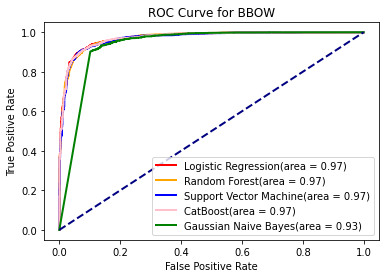

,BBOW
Logistic Regression,0.920322
Random Forest,0.915880
Support Vector Machine,0.912549
CatBoost,0.913104
Gaussian Naive Bayes,0.899500


In [ ]:
BG_EST = [clf_BBoW_LR, 
          clf_BBoW_RF, 
          clf_BBoW_SVM, 
          clf_BBoW_CB, 
          clf_BBoW_GNB]
summary(BG_EST, bigram_test,Y_test, "BBOW")

Feature Importance
> Logistic Regression

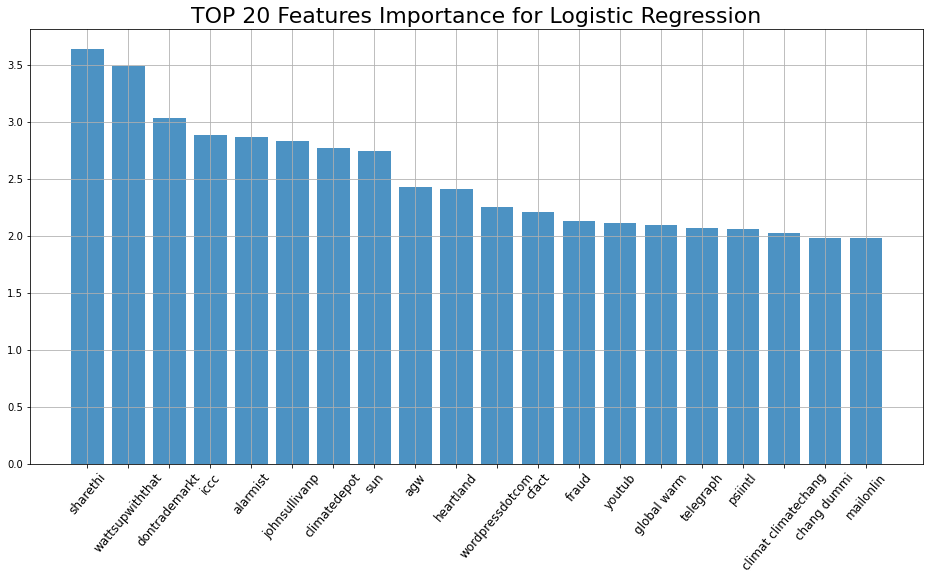

In [ ]:
importance = clf_BBoW_LR.coef_[0]

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = bigram_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Logistic Regression',fontsize=22)
plt.grid()
plt.show()

> Random Forest

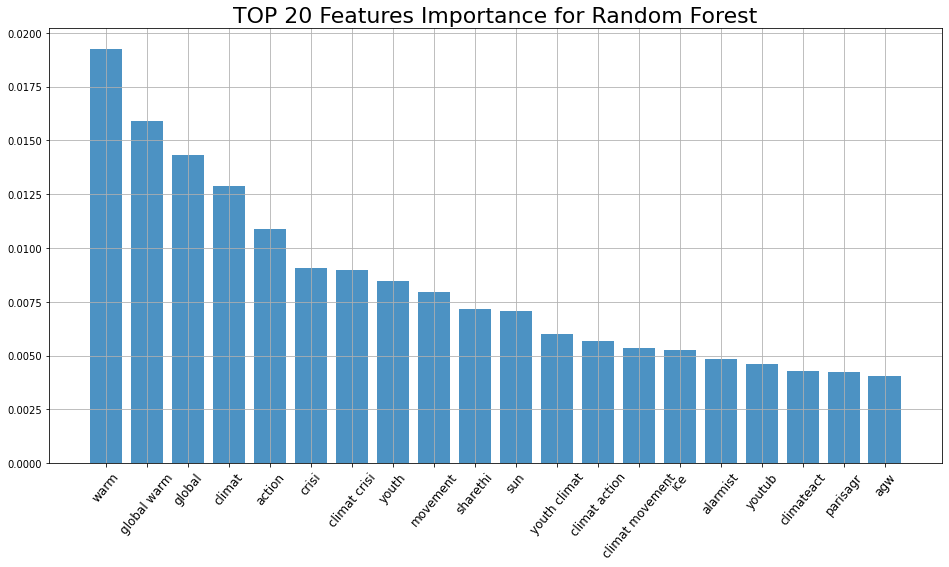

In [ ]:
importance = clf_BBoW_RF.feature_importances_

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = bigram_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Random Forest',fontsize=22)
plt.grid()
plt.show()

> CatBoost

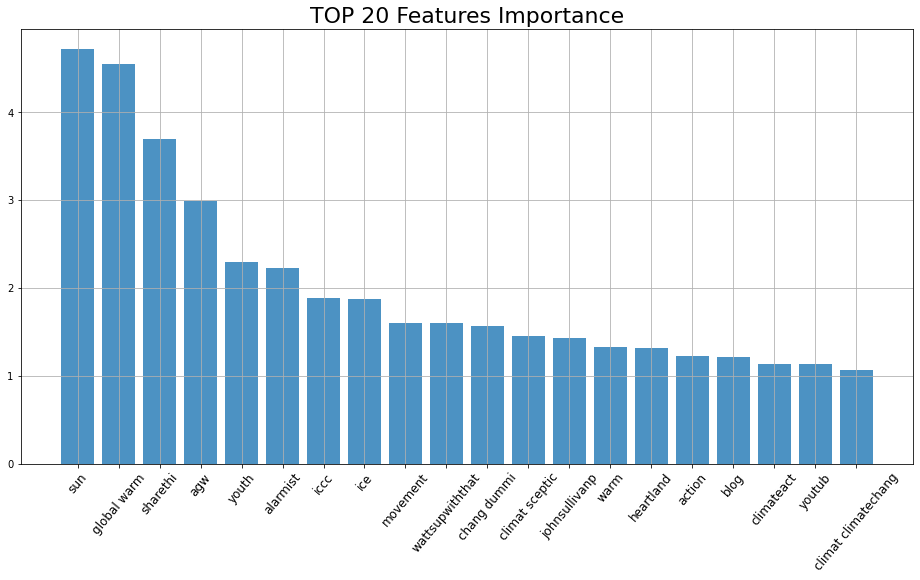

In [ ]:
importance = clf_BBoW_CB.get_feature_importance()

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = bigram_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()



*   Term Frequency–Inverse Document Frequency Representation (tf-idf) Scaled


> Logistic Regression



In [ ]:
#param_grid = {
#            'penalty': ['elasticnet','l1','l2','none'],
#            'C': [.001, .01, .1, 1, 10, 100, 1000],
#            'solver': ['liblinear', "saga", "lbfgs", "newton-cg", "sag"],
#            'multi_class': ['ovr'],
#            'max_iter' : [1000]
#        }
#grid_search_LR = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2)
#grid_search_LR.fit(tfidf_train_scaled,Y_train)
#clear_output()
#print("## Best Logistic Regression parameters with TFIDF Scaled embedding :", grid_search_LR.best_params_)

In [ ]:
clf_TFIDF_LR_S = LogisticRegression(C = 1, l1_ratio = 0.2,  penalty = "elasticnet", max_iter = 1000, multi_class = "ovr", solver = "saga")
clf_TFIDF_LR_S.fit(tfidf_train_scaled, Y_train)
clear_output()



> Random Forests





In [ ]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 100, None],
#    'max_features': ['sqrt', 'log2'],
#    'min_samples_leaf': [1, 3, 5],
#    'min_samples_split': [2, 5, 10],
#    'n_estimators': [50, 100, 300]
#}
#grid_search_RF = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_RF.fit(tfidf_train_scaled,Y_train)
#clear_output()
#print("## Best Random Forest parameters with TFIDF Scaled embedding :", grid_search_RF.best_params_)


In [ ]:
clf_TFIDF_RF_S = RandomForestClassifier(bootstrap = True,
                                     max_depth = None, 
                                     max_features = "log2",
                                     min_samples_leaf = 1,
                                     min_samples_split = 2, 
                                     n_estimators = 300)
clf_TFIDF_RF_S.fit(tfidf_train_scaled, Y_train)
clear_output()



> Support Vector Machine





In [ ]:
#param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1,2,10,100]},
#                    {'kernel': ['linear'], 'C': [1,2,10,100]}]
#grid_search_SVM = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_SVM.fit(tfidf_train_scaled,Y_train)
#clear_output()
#print("## Best Super Vector Machines parameters with TFIDF Scaled embedding :", grid_search_SVM.best_params_)

In [ ]:
clf_TFIDF_SVM_S = SVC(probability =True, C = 100, gamma = 0.001, kernel='rbf' )
clf_TFIDF_SVM_S.fit(tfidf_train_scaled, Y_train)
clear_output()

> Cat Boost

In [ ]:
#param_grid = {'n_estimators':[100,250,500,1000],
#              'depth':sp_randint(1,10),
#              'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3], 
#              'l2_leaf_reg':[1,5,10,100],
#              'border_count':[5,10,20,50,100,200]}
#n_HP_points_to_test = 60
#grid_search_CB = RandomizedSearchCV(
#    estimator=cb.CatBoostClassifier(random_state=17,thread_count=4,verbose=0), 
#    param_distributions=param_grid, 
#    n_iter=n_HP_points_to_test,
#    scoring='accuracy',
#    cv=kfcv,
#    refit=True,
#    random_state=17,
#    n_jobs=-1,
#    verbose=5)
#grid_search_CB.fit(tfidf_train_scaled,Y_train)
#clear_output()
#print("## Best Cat Boost parameters with TFIDF Scaled embedding :", grid_search_CB.best_params_)

In [ ]:
clf_TFIDF_CB_S =  cb.CatBoostClassifier(border_count = 5, 
                                    depth = 9, 
                                    l2_leaf_reg = 5, 
                                    learning_rate = 0.1,
                                    n_estimators = 500,
                                    random_state=17,thread_count=4,verbose=0)
clf_TFIDF_CB_S.fit(tfidf_train_scaled, Y_train)
clear_output()


> Gaussian Naives Bayes

In [ ]:
#var_smoothing = [pow(10,k)/1000000000 for k in range(10)]
#param_grid = {
#           'alpha': var_smoothing
#        }
#grid_search_NB = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_NB.fit(tfidf_train_scaled,Y_train)
#clear_output()
#print("## Best Gaussian Naives Bayes parameters with TFIDF Scaled embedding :", grid_search_NB.best_params_)

In [ ]:
clf_TFIDF_GNB_S =  GaussianNB(var_smoothing=0.01)
clf_TFIDF_GNB_S.fit(tfidf_train_scaled.toarray(), Y_train)
clear_output()

Accuracy and visualisation of the results 

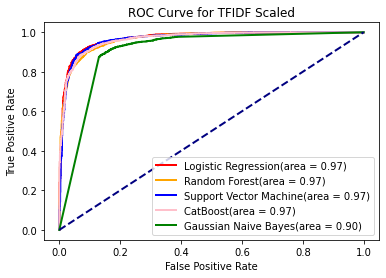

,TFIDF Scaled
Logistic Regression,0.915325
Random Forest,0.902832
Support Vector Machine,0.913381
CatBoost,0.908107
Gaussian Naive Bayes,0.875625


In [ ]:
BG_EST = [clf_TFIDF_LR_S,
          clf_TFIDF_RF_S,
          clf_TFIDF_SVM_S,
          clf_TFIDF_CB_S,
          clf_TFIDF_GNB_S]
summary(BG_EST, tfidf_test_scaled,Y_test, "TFIDF Scaled")

Feature Importance
> Logistic Regression

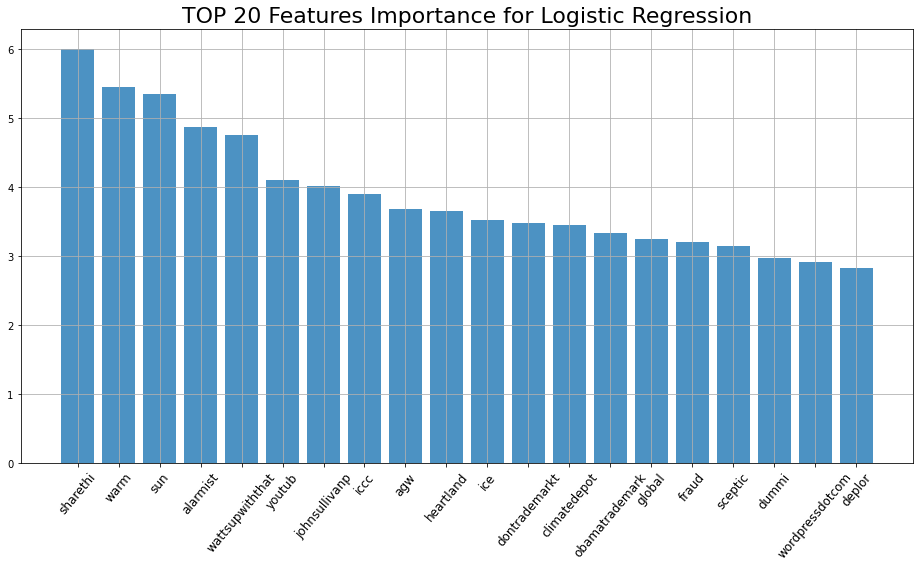

In [ ]:
importance = clf_TFIDF_LR_S.coef_[0]

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = tfidf_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Logistic Regression',fontsize=22)
plt.grid()
plt.show()

> Random Forest

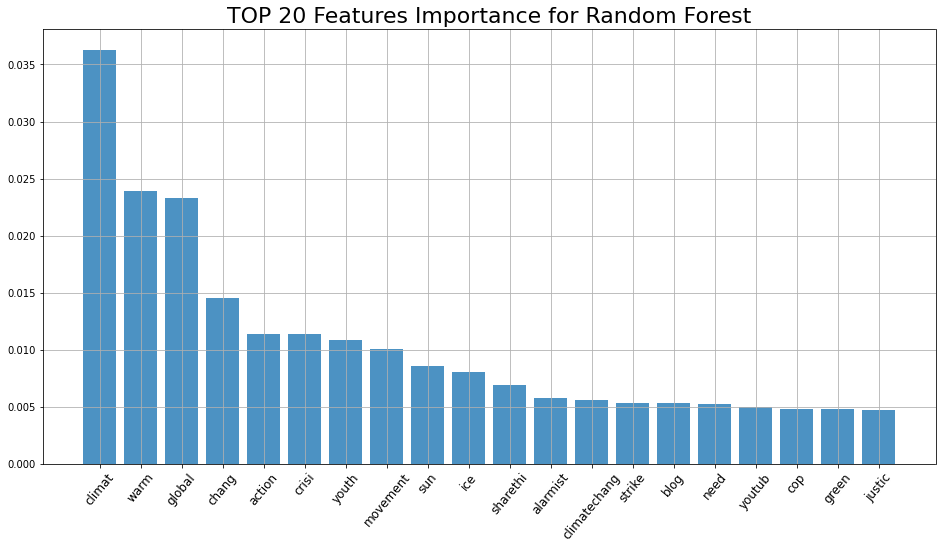

In [ ]:
importance = clf_TFIDF_RF_S.feature_importances_

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = tfidf_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Random Forest',fontsize=22)
plt.grid()
plt.show()

> CatBoost

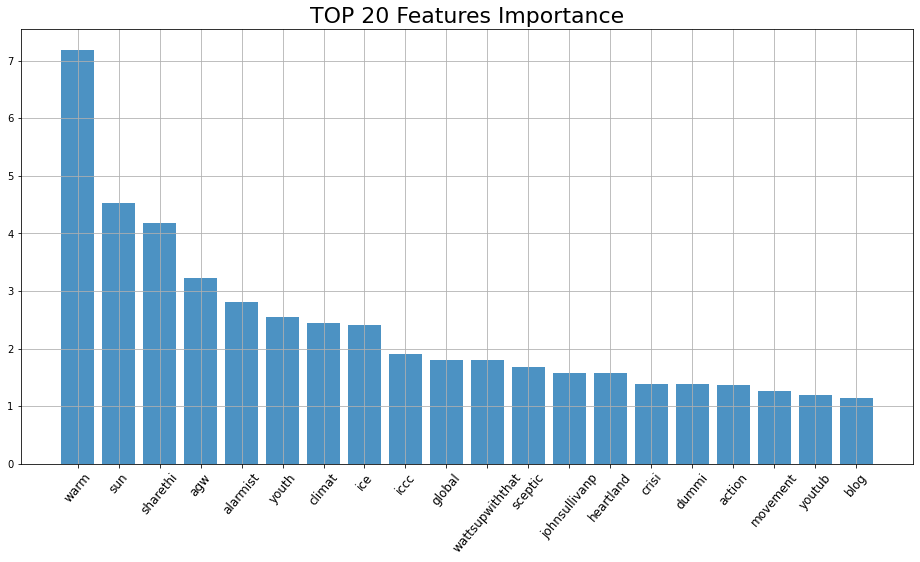

In [ ]:
importance = clf_TFIDF_CB_S.get_feature_importance()

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = tfidf_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()



*   Term Frequency–Inverse Document Frequency Representation (tf-idf) Non Scaled


> Logistic Regression



In [ ]:
#param_grid = {
#            'penalty': ['elasticnet','l1','l2','none'],
#            'C': [.001, .01, .1, 1, 10, 100, 1000],
#            'solver': ['liblinear', "saga", "lbfgs", "newton-cg", "sag"],
#            'multi_class': ['ovr'],
#            'max_iter' : [1000]
#        }
#grid_search_LR = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 2)
#grid_search_LR.fit(tfidf_train,Y_train)
#clear_output()
#print("## Best Logistic Regression parameters with TFIDF embedding :", grid_search_LR.best_params_)

In [ ]:
clf_TFIDF_LR_NS = LogisticRegression(C = 1, l1_ratio = 0.2,  penalty = "elasticnet", max_iter = 1000, multi_class = "ovr", solver = "saga")
clf_TFIDF_LR_NS.fit(tfidf_train, Y_train)
clear_output()



> Random Forests





In [ ]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 100, None],
#    'max_features': ['sqrt', 'log2'],
#    'min_samples_leaf': [1, 3, 5],
#    'min_samples_split': [2, 5, 10],
#    'n_estimators': [50, 100, 300]
#}
#grid_search_RF = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_RF.fit(tfidf_train,Y_train)
#clear_output()
#print("## Best Random Forest parameters with TFIDF embedding :", grid_search_RF.best_params_)


In [ ]:
clf_TFIDF_RF_NS = RandomForestClassifier(bootstrap = True,
                                     max_depth = None, 
                                     max_features = "log2",
                                     min_samples_leaf = 1,
                                     min_samples_split = 10, 
                                     n_estimators = 300)
clf_TFIDF_RF_NS.fit(tfidf_train, Y_train)
clear_output()



> Support Vector Machine





In [ ]:
#param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1,2,10,100]},
#                    {'kernel': ['linear'], 'C': [1,2,10,100]}]
#grid_search_SVM = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_SVM.fit(tfidf_train,Y_train)
#clear_output()
#print("## Best Super Vector Machines parameters with TFIDF embedding :", grid_search_SVM.best_params_)

In [ ]:
clf_TFIDF_SVM_NS = SVC(probability =True, C = 100, gamma = 0.001, kernel='rbf' )
clf_TFIDF_SVM_NS.fit(tfidf_train, Y_train)
clear_output()


> Gaussian Naives Bayes

In [ ]:
#var_smoothing = [pow(10,k)/1000000000 for k in range(10)]
#param_grid = {
#           'alpha': var_smoothing
#        }
#grid_search_NB = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid, cv=kfcv ,n_jobs = -1, verbose = 5)
#grid_search_NB.fit(tfidf_train,Y_train)
#clear_output()
#print("## Best Gaussian Naives Bayes parameters with TFIDF embedding :", grid_search_NB.best_params_)

In [ ]:
clf_TFIDF_GNB_NS =  GaussianNB(var_smoothing=0.01)
clf_TFIDF_GNB_NS.fit(tfidf_train.toarray(), Y_train)
clear_output()

Accuracy and visualisation of the results 

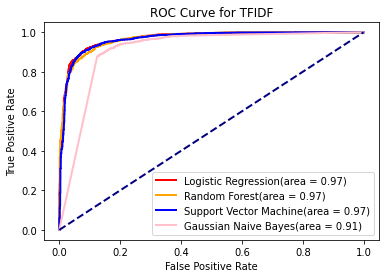

,TFIDF
Logistic Regression,0.913381
Random Forest,0.905608
Support Vector Machine,0.910050
Gaussian Naive Bayes,0.877290


In [ ]:
BG_EST = [clf_TFIDF_LR_NS,
          clf_TFIDF_RF_NS, 
          clf_TFIDF_SVM_NS,
          clf_TFIDF_GNB_NS]
summary(BG_EST, tfidf_test,Y_test, "TFIDF", cb = False)

Feature Importance
> Logistic Regression

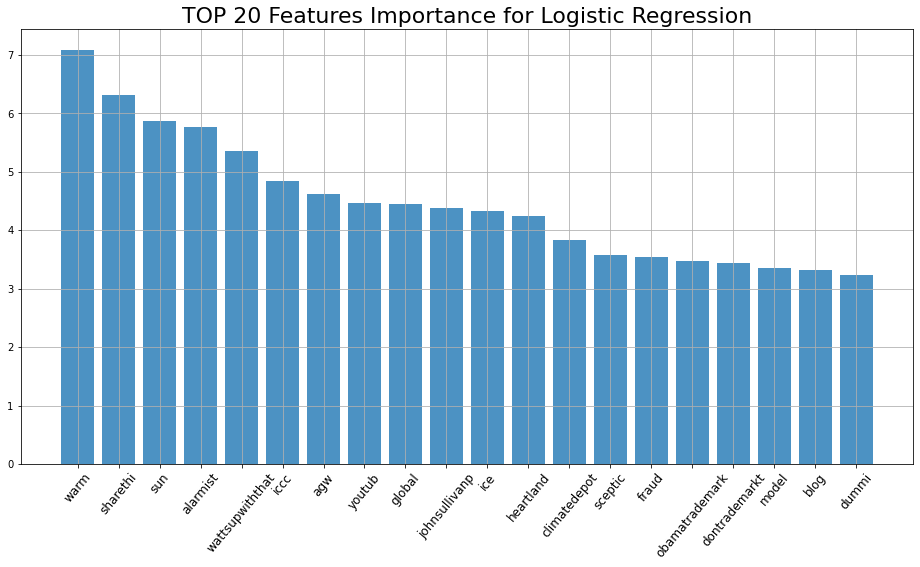

In [ ]:
importance = clf_TFIDF_LR_NS.coef_[0]

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = tfidf_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Logistic Regression',fontsize=22)
plt.grid()
plt.show()

> Random Forest

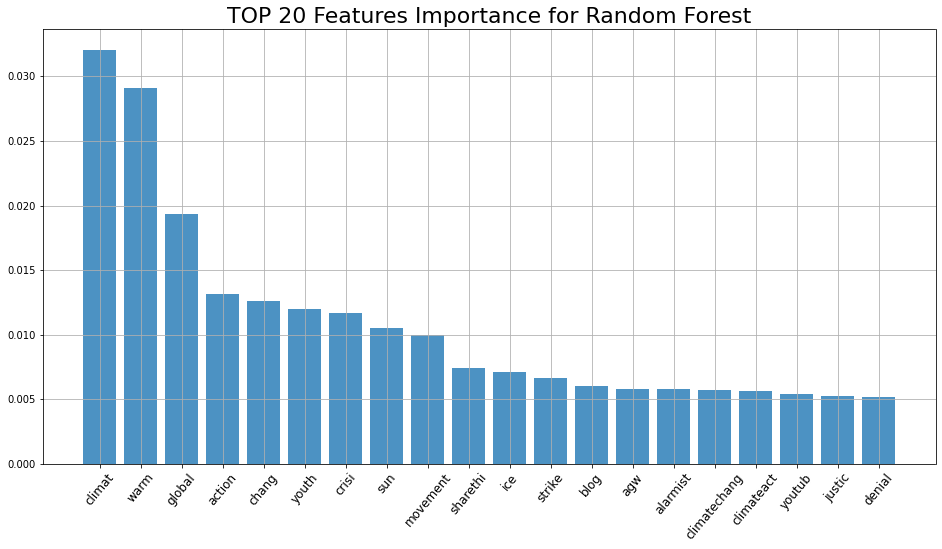

In [ ]:
importance = clf_TFIDF_RF_NS.feature_importances_

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = tfidf_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance for Random Forest',fontsize=22)
plt.grid()
plt.show()

In [ ]:
print("Execution Time without word2vec and soft voting model ", (time.time() - start_time))

Execution Time without word2vec and soft voting model  619.0650787353516


-------> **After this I haven't one anything** <--------

## Custom majority vote model

In [ ]:
class Majority_vote():
    """
    averaging all models
    """
    def __init__(self,models,threshold=None):
        self.base_models = models
        if threshold:
            self.threshold = threshold
        else:
            self.threshold = 0.5
              
    
    def fit(self,X_train,y_train):
        for model in self.base_models:       
            model.fit(X_train,y_train)

    def predict_score(self,X):
        s = []
        for k,model in enumerate(self.base_models):
            pred = model.predict_proba(X)[:,1]
            s.append(pred)
        s = np.array(s)
        return(np.sum(s,axis=0)/len(self.base_models))
    
    def predict(self,X):
        score = self.predict_score(X)
        pred = np.zeros(X.shape[0])
        pred[score>=self.threshold] = 1
        return pred

![dd](https://miro.medium.com/max/700/1*EekXroXi99N05jcskdPsIg.png)

In [ ]:
estimators = [RandomForestClassifier(**{'bootstrap': True,'max_depth': None,'max_features': 'log2',
                                        'min_samples_leaf': 1,'min_samples_split': 10,'n_estimators': 300,
                                        'random_state':17}),
              SVC(**{'C': 100, 'gamma': 0.001, 'kernel': 'rbf','probability':True,'random_state':17}),
              LogisticRegression(**{'C':1,'max_iter':1000, 'multi_class':"ovr", 'solver':"saga",'random_state':17}),
              cb.CatBoostClassifier(**{"border_count": 200, "depth": 6, "l2_leaf_reg": 10,
                                       "learning_rate": 0.3, "n_estimators": 1000,'verbose':0,'random_state':17})]

kfcv = KFold(n_splits=3,shuffle=True,random_state=101)

In [ ]:
best = 0
threshold = 0.5

X_train = BOW_train
y_train = Y_train

for t in tqdm_notebook([0.4,0.45,0.5,0.55,0.6]):

    score_accuracy = []
    for train_index, val_index in kfcv.split(X_train,y_train):
        XX_train, XX_val = X_train[train_index], X_train[val_index]
        yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
        clf = Majority_vote(estimators,threshold=t)
        clf.fit(XX_train,yy_train)
        pred = clf.predict(XX_val)
        accuracy = accuracy_score(yy_val,pred)
        score_accuracy.append(accuracy)
        
    if np.mean(score_accuracy) >= best:
        best = np.mean(score_accuracy)
        threshold = t

print(best)
print(threshold)

In [ ]:
clf = Majority_vote(estimators,threshold=0.55)
clf.fit(X_train,y_train)

In [ ]:
def plot_figure(X,y,clf):
    '''Plots Precision-Recall & ROC curves'''

    y_score = clf.predict_score(X)
    average_precision = average_precision_score(y, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))




    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    #plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    
    plt.show()

In [ ]:
X_test = BOW_test
y_test = Y_test

pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)
f5 = fbeta_score(y_test,pred,beta=5)
y_score = clf.predict_score(X_test)
auc_score = roc_auc_score(y_test,y_score)
brier_score = brier_score_loss(y_test, y_score)


print('#######################\n')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))
print('F5_score: {}'.format(round(f5,4)))
print('AUC_score: {}'.format(round(auc_score,4)))
print('1-Brier_score: {}'.format(round(1-brier_score,4)))
print()
print('#######################\n')


plot_figure(X_test,y_test,clf)